In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os
import glob as gb
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB1, ResNet50
from tensorflow.keras.applications.vgg16 import VGG16



from sklearn.metrics import classification_report, confusion_matrix

2025-07-11 17:05:50.857254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752253550.880545    1278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752253550.888069    1278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
    MOD_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
    path = "/kaggle/input/teeth-dataset1/Teeth_Dataset/"

In [5]:
# reading and normalizing
def data_preparation(path,img_dim):
    X = []
    y = []

    for folder in os.listdir(path):
        files = gb.glob(pathname = str(path + '/' + folder + '/*jpg'))
        for file in files:
          image = cv2.imread(file)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image_array = cv2.resize(image, (img_dim, img_dim))
          X.append(image_array)
          y.append(MOD_classes.index(folder))
    X = np.array(X) / 255
    y = np.array(y)
        
    return X, y

# Reading Images

In [6]:
X_train, y_train = data_preparation(path + 'Training', 224)
X_test, y_test = data_preparation(path + 'Testing', 224)
X_validate, y_validate = data_preparation(path + 'Validation', 224)

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,     # Slight horizontal shifts
    height_shift_range=0.1,    # Slight vertical shifts
    horizontal_flip=True,      # Faces can appear mirrored
)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# Model1 -> VGG16

In [23]:
VGG16_base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

VGG16_base_model.trainable = False

VGG16_base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
VGG16_model = Sequential()

VGG16_model.add(VGG16_base_model)

VGG16_model.add(GlobalAveragePooling2D())

VGG16_model.add(Dense(128, activation = 'relu'))
VGG16_model.add(Dropout(0.2))

VGG16_model.add(Dense(7, activation = 'softmax'))

VGG16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
VGG16_model.compile(optimizer = Adam(learning_rate=0.0001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#Callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience= 20, restore_best_weights= True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00001)

In [27]:
history1 = VGG16_model.fit(X_train,
               y_train,
               validation_data = (X_validate, y_validate),
               epochs= 50,
               callbacks= [early_stop])

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.1526 - loss: 1.9921 - val_accuracy: 0.2257 - val_loss: 1.8768
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.2201 - loss: 1.9044 - val_accuracy: 0.3093 - val_loss: 1.8260
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.2834 - loss: 1.8164 - val_accuracy: 0.4027 - val_loss: 1.7758
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.3130 - loss: 1.7729 - val_accuracy: 0.4465 - val_loss: 1.7300
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.3561 - loss: 1.7337 - val_accuracy: 0.4183 - val_loss: 1.6847
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.4055 - loss: 1.6720 - val_accuracy: 0.4523 - val_loss: 1.6439
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.4259 - loss: 1.6339 - val_accuracy: 0.4446 - val_loss: 1.6082
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.4489 - loss: 1.5872 - val_accu

In [32]:
VGG16_base_model.trainable = True

0 input_layer_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [33]:
VGG16_model.compile(optimizer=Adam(learning_rate=1e-5),  # lower LR to avoid breaking pretrained weights
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history2 = VGG16_model.fit(X_train,
          y_train,
          validation_data= (X_validate, y_validate),
          epochs=20)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 67s 612ms/step - accuracy: 0.6734 - loss: 0.9059 - val_accuracy: 0.7977 - val_loss: 0.5803
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 551ms/step - accuracy: 0.8369 - loss: 0.4929 - val_accuracy: 0.8716 - val_loss: 0.3970
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 548ms/step - accuracy: 0.9310 - loss: 0.2475 - val_accuracy: 0.9368 - val_loss: 0.2187
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 550ms/step - accuracy: 0.9688 - loss: 0.1327 - val_accuracy: 0.9601 - val_loss: 0.1365
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 551ms/step - accuracy: 0.9788 - loss: 0.0729 - val_accuracy: 0.9339 - val_loss: 0.1819
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 550ms/step - accuracy: 0.9880 - loss: 0.0565 - val_accuracy: 0.9251 - val_loss: 0.1915
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 549ms/step - accuracy: 0.9858 - loss: 0.0428 - val_accuracy: 0.9426 - val_loss: 0.1598
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 549ms/step - accuracy: 0.9904 - loss: 0.0416 - val_accu

# Evaluating

In [34]:
evaluation = VGG16_model.evaluate(X_test, y_test)
print("Loss of Model: ", evaluation[0])
print("Accuracy of Model:", round(evaluation[1]*100,2),'%')

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.9789 - loss: 0.0633
Loss of Model:  0.041659824550151825
Accuracy of Model: 98.44 %


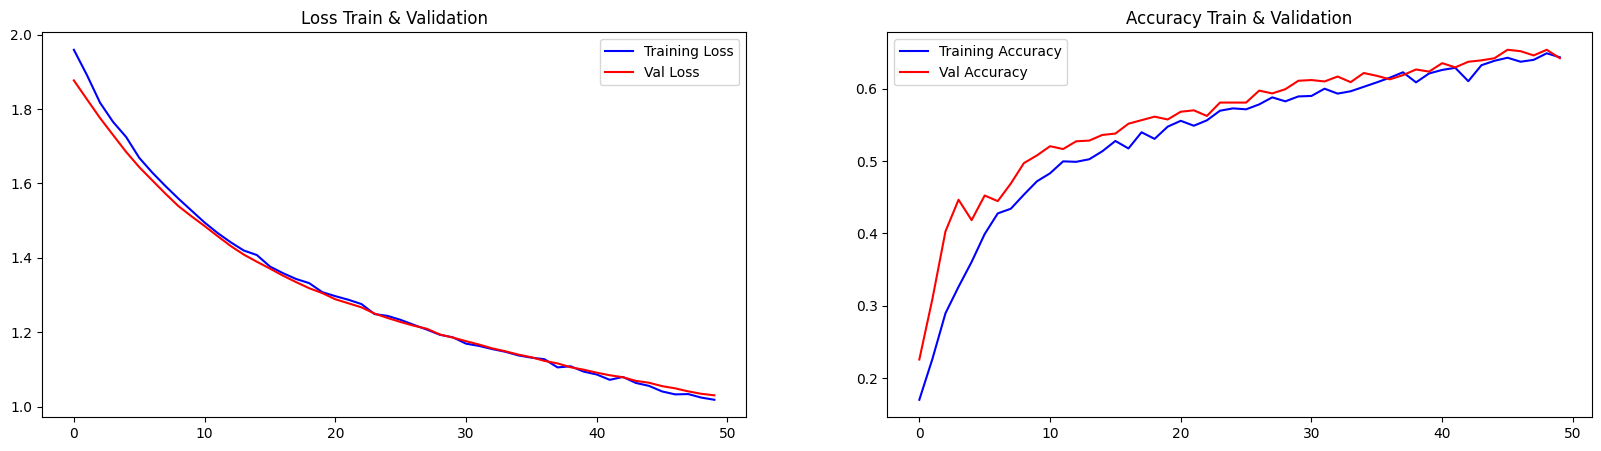

In [39]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.lineplot(x=history1.epoch, y=history1.history['loss'], color='blue', label='Training Loss')
sns.lineplot(x=history1.epoch, y=history1.history['val_loss'], color='red', label='Val Loss')
plt.title('Loss Train & Validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=history1.epoch, y=history1.history['accuracy'], color='blue', label='Training Accuracy')
sns.lineplot(x=history1.epoch, y=history1.history['val_accuracy'], color='red', label='Val Accuracy')
plt.title('Accuracy Train & Validation')
plt.legend(loc='best')

plt.show()

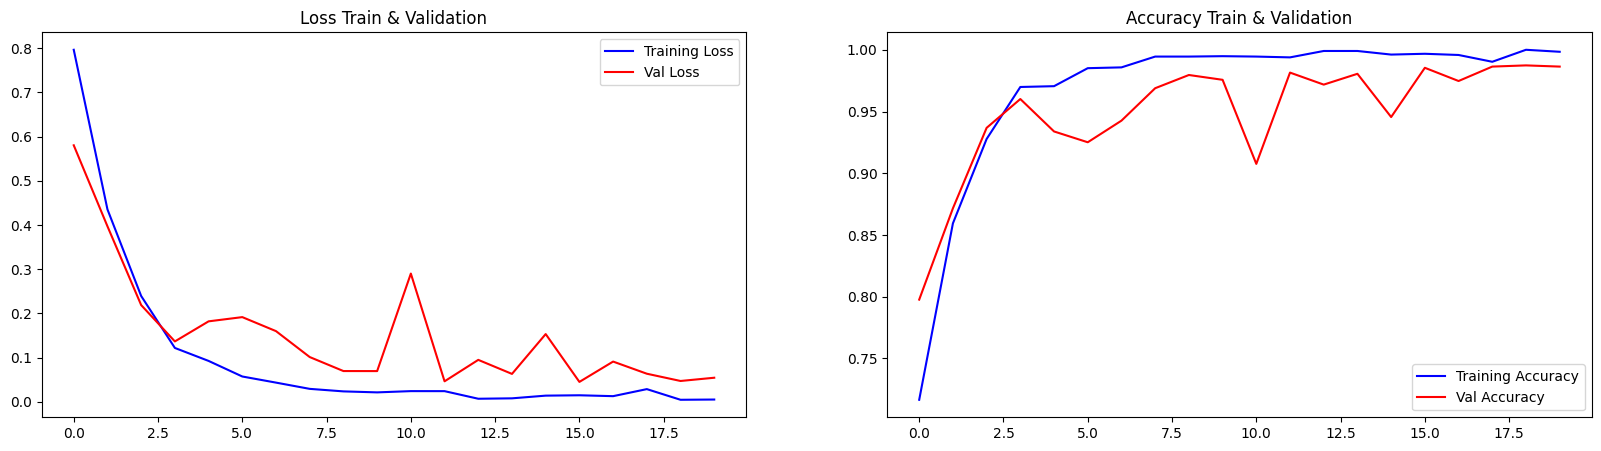

In [40]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.lineplot(x=history2.epoch, y=history2.history['loss'], color='blue', label='Training Loss')
sns.lineplot(x=history2.epoch, y=history2.history['val_loss'], color='red', label='Val Loss')
plt.title('Loss Train & Validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=history2.epoch, y=history2.history['accuracy'], color='blue', label='Training Accuracy')
sns.lineplot(x=history2.epoch, y=history2.history['val_accuracy'], color='red', label='Val Accuracy')
plt.title('Accuracy Train & Validation')
plt.legend(loc='best')

plt.show()

In [41]:
predicitions = VGG16_model.predict(X_test)

predicitions = np.argmax(predicitions, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step


In [42]:
print(classification_report(y_test, predicitions, target_names=MOD_classes))

              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       1.00      0.99      1.00       149
         Gum       1.00      0.98      0.99       120
          MC       0.98      0.98      0.98       180
          OC       0.94      0.96      0.95       108
         OLP       0.99      0.98      0.99       180
          OT       0.98      0.99      0.99       131

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028



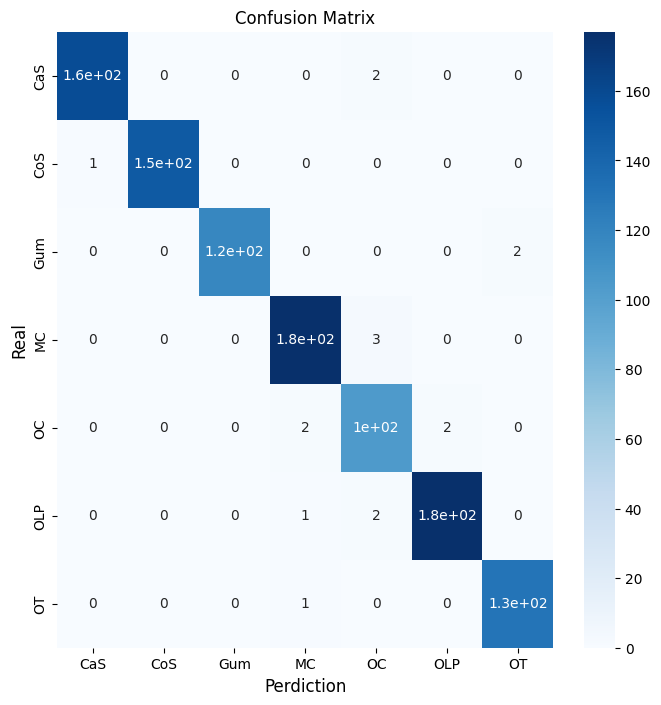

In [43]:
cm = confusion_matrix(y_test, predicitions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels= MOD_classes, yticklabels=MOD_classes, cmap='Blues')
plt.xlabel('Perdiction',fontsize = 12, color='black')
plt.ylabel('Real', fontsize = 12, color='black')
plt.title('Confusion Matrix')
plt.show()

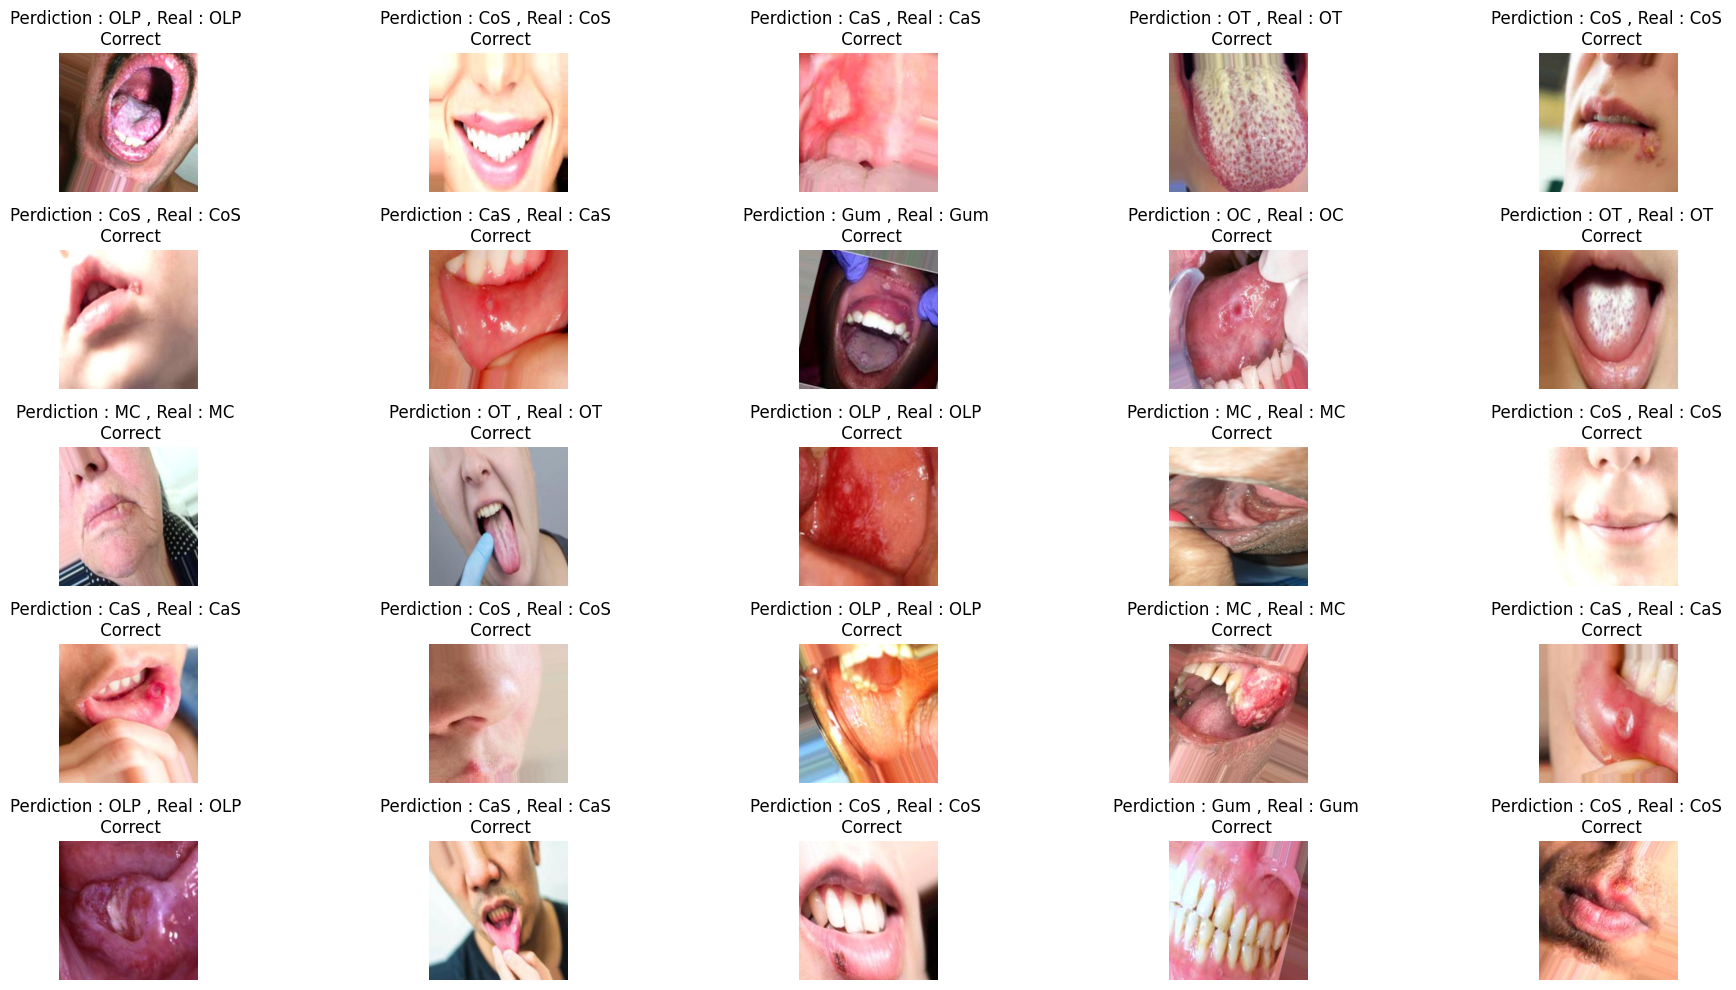

In [44]:
plt.figure(figsize=(20,10))
for i in range(25):
    img_no = np.random.randint(0, X_test.shape[0])
    pred = MOD_classes[predicitions[img_no]]
    real = MOD_classes[y_test[img_no]]
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[img_no],cmap='gray')
    plt.grid('off')
    plt.axis('off')
    
    if pred == real:   
        plt.title(f'Perdiction : {pred} , Real : {real} \n Correct')
    else:
        plt.title(f'Perdiction : {pred} , Real : {real} \n Wrong')
        
plt.tight_layout()
plt.show()

In [45]:
VGG16_model.save('teeth_vgg16_model.h5')